# ML

#### Notebook to demonstrate some analytical considerations in the feature engineering and preprocessing

# Extraction

#### Pulling Raw Data From databases

In [1]:
import psycopg2
import pandas as pd
from psycopg2 import sql, Error

def load_tables_to_dataframes(host, port, database, username, password):
    conn = None
    dataframes = {}

    try:
        conn = psycopg2.connect(
            host=host,
            port=port,
            dbname=database,
            user=username,
            password=password
        )

        # Load historical_price with 6 months filter (2025-06 onwards)
        historical_query = """
            SELECT * FROM historical_price 
            WHERE time >= '2025-04-30'
        """
        dataframes['historical_price'] = pd.read_sql_query(historical_query, conn)

        # Load full news_sentiment table
        news_query = "SELECT * FROM news_sentiment"
        dataframes['news_sentiment'] = pd.read_sql_query(news_query, conn)

        # Load fear_and_greed with 6 months filter (2025-06 onwards)
        greed_query = """
            SELECT * FROM fear_greed_index 
            WHERE time >= '2025-05-13'
        """
        dataframes['fear_greed_index'] = pd.read_sql_query(greed_query, conn)

    except Error as e:
        print(f"❌ Database error: {e}")
    finally:
        if conn:
            conn.close()

    return dataframes

In [2]:
from configs.config import DB_CONFIG

HOST= "localhost"
PORT=DB_CONFIG["port"]
USER=DB_CONFIG["user"]
PASS=DB_CONFIG["password"]
DB_NAME = DB_CONFIG["dbname"]

dataframes = load_tables_to_dataframes(
    HOST,
    PORT,
    DB_NAME,
    USER,
    PASS
)

❌ Database error: connection to server at "localhost" (::1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?



In [3]:
# For the loaded dataframes:
historical_price = dataframes['historical_price']      # 6 months from 2025-06 onwards
news_sentiment = dataframes['news_sentiment']          # full table
fear_greed = dataframes['fear_greed_index']            # 6 months from 20

KeyError: 'historical_price'

In [ ]:
# historical_price.to_csv("training_data/price_data.csv")
# news_sentiment.to_csv("training_data/news_data.csv")
# fear_greed.to_csv("training_data/fear_greed.csv")

In [ ]:
# Get max and min for time columns
price_time_max = historical_price['time'].max()
price_time_min = historical_price['time'].min()

sentiment_time_max = news_sentiment['time'].max()
sentiment_time_min = news_sentiment['time'].min()

greed_time_max = fear_greed['time'].max()
greed_time_min = fear_greed['time'].min()

print(f"Historical Price - Min: {price_time_min}, Max: {price_time_max}")
print(f"News Sentiment - Min: {sentiment_time_min}, Max: {sentiment_time_max}")
print(f"Fear Greed - Min: {greed_time_min}, Max: {greed_time_max}")

Historical Price - Min: 2025-04-30 00:00:00+00:00, Max: 2025-11-06 02:00:00+00:00
News Sentiment - Min: 2025-05-13 22:51:01+00:00, Max: 2025-11-06 01:34:17+00:00
Fear Greed - Min: 2025-05-13 00:00:00+00:00, Max: 2025-11-06 00:00:00+00:00


### Plot price against fear and greed

In [506]:
historical_price

,time,open,high,low,close,volume
0,2025-04-30 00:00:00+00:00,94284.00,94284.00,94242.00,94261.00,0.692943
1,2025-04-30 00:01:00+00:00,94261.00,94340.00,94241.00,94340.00,0.605250
2,2025-04-30 00:02:00+00:00,94305.00,94310.00,94272.00,94272.00,0.017048
3,2025-04-30 00:03:00+00:00,94251.00,94251.00,94169.00,94202.00,0.628900
4,2025-04-30 00:04:00+00:00,94202.00,94202.00,94175.00,94202.00,0.002028
...,...,...,...,...,...,...
273716,2025-11-06 01:55:00+00:00,103413.30,103434.55,103413.29,103434.54,1.450570
273717,2025-11-06 01:56:00+00:00,103434.55,103470.46,103413.63,103413.63,3.669970
273718,2025-11-06 01:57:00+00:00,103413.63,103436.42,103413.63,103425.20,2.756850
273719,2025-11-06 01:58:00+00:00,103425.20,103425.20,103388.60,103388.61,5.063620


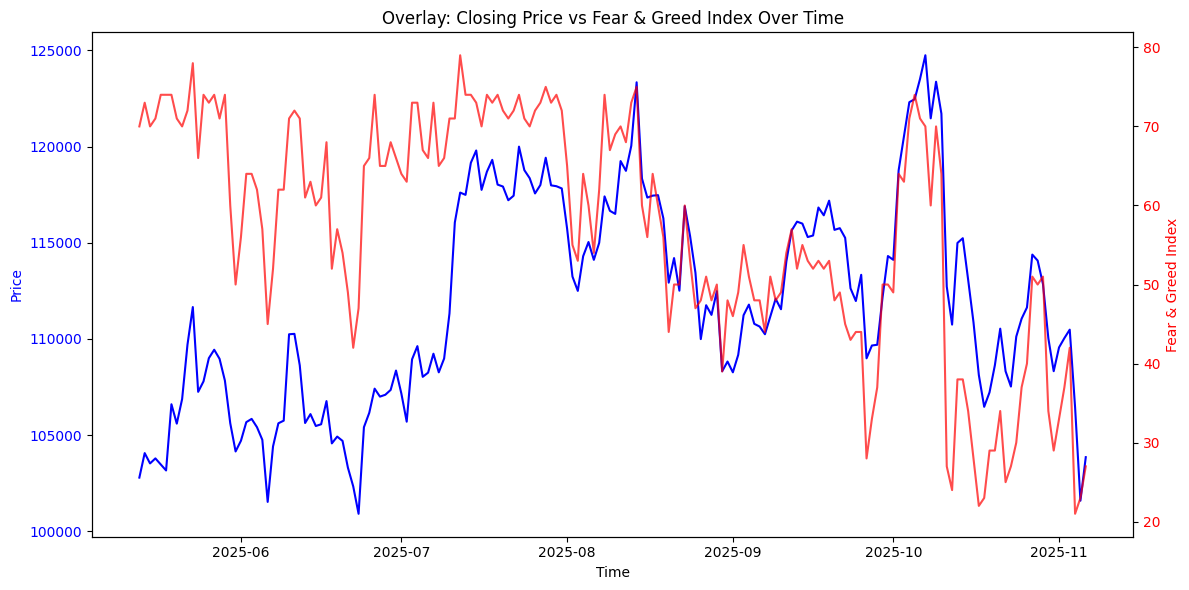

In [507]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure time columns are datetime
historical_price['time'] = pd.to_datetime(historical_price['time'])
fear_greed['time'] = pd.to_datetime(fear_greed['time'])

# Merge datasets on overlapping time values
merged_df = pd.merge(historical_price, fear_greed, on='time', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot closing price on left y-axis
ax1.plot(merged_df['time'], merged_df['close'], color='blue', label='Closing Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Fear & Greed Index on right y-axis
ax2 = ax1.twinx()
ax2.plot(merged_df['time'], merged_df['value'], color='red', label='Fear & Greed Index', alpha=0.7)
ax2.set_ylabel('Fear & Greed Index', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and layout
plt.title('Overlay: Closing Price vs Fear & Greed Index Over Time')
fig.tight_layout()
plt.show()


# Preprocessing + Feature Engineering

#### Sort all values by time first

In [508]:
historical_price = historical_price.sort_values("time")
news_sentiment = news_sentiment.sort_values("time")
fear_greed = fear_greed.sort_values("time")

## Preprocessing For News Sentiment

### Determining the best bin and interval granularity for news data

In [509]:
import pandas as pd
import numpy as np

def analyze_bin_distribution(df: pd.DataFrame, freq: str) -> dict:
    """
    Analyze article distribution for a given bin frequency
    
    Returns statistics about bin efficiency
    """
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    # Resample into bins
    bins = df.resample(freq)
    
    # Count articles per bin
    bin_counts = bins.size()  # Returns Series with bin start times as index
    
    # Calculate metrics
    total_bins = len(bin_counts)
    non_empty_bins = (bin_counts > 0).sum()
    empty_bins = total_bins - non_empty_bins
    total_articles = bin_counts.sum()
    
    # Efficiency metrics
    avg_articles_per_bin = total_articles / total_bins if total_bins > 0 else 0
    avg_articles_per_nonempty_bin = total_articles / non_empty_bins if non_empty_bins > 0 else 0
    empty_bin_ratio = empty_bins / total_bins if total_bins > 0 else 0
    pct_empty = empty_bin_ratio * 100  # ← NEW: percentage as 0-100
    
    # Distribution percentiles
    non_empty_counts = bin_counts[bin_counts > 0]
    if len(non_empty_counts) > 0:
        percentiles = np.percentile(non_empty_counts, [25, 50, 75, 90, 95])
    else:
        percentiles = [0, 0, 0, 0, 0]
    
    return {
        'frequency': freq,
        'total_bins': total_bins,
        'non_empty_bins': non_empty_bins,
        'empty_bins': empty_bins,
        'empty_bin_ratio': empty_bin_ratio,
        'pct_empty': pct_empty,
        'avg_articles_per_bin': avg_articles_per_bin,
        'avg_articles_per_nonempty_bin': avg_articles_per_nonempty_bin,
        'p25_articles': percentiles[0],
        'p50_articles': percentiles[1],
        'p75_articles': percentiles[2],
        'p90_articles': percentiles[3],
        'p95_articles': percentiles[4],
        'max_articles_in_bin': non_empty_counts.max() if len(non_empty_counts) > 0 else 0
    }

In [510]:
def find_optimal_bin_size(
    df: pd.DataFrame,
    frequencies: list = None
) -> pd.DataFrame:
    """
    Evaluate multiple bin frequencies and return comparison DataFrame
    
    Default frequencies cover common crypto trading intervals
    """
    if frequencies is None:
        frequencies = [
            '1min',   # 1 minute
            '2min',   # 2 minutes  
            '3min',   # 3 minutes
            '5min',   # 5 minutes
            '10min',  # 10 minutes
            '15min',  # 15 minutes
            '30min',  # 30 minutes
            '1h',   # 1 hour
            '2h',   # 2 hours
            '4h',   # 4 hours
            '6h',   # 6 hours
            '12h',  # 12 hours
            '1d'    # 1 day
        ]
    
    results = []
    for freq in frequencies:
        try:
            stats = analyze_bin_distribution(df, freq)
            results.append(stats)
        except Exception as e:
            print(f"Failed for frequency {freq}: {e}")
            continue
    
    return pd.DataFrame(results)

In [511]:
bin_analysis = find_optimal_bin_size(news_sentiment)
print(bin_analysis.to_string(index=False))

frequency  total_bins  non_empty_bins  empty_bins  empty_bin_ratio  pct_empty  avg_articles_per_bin  avg_articles_per_nonempty_bin  p25_articles  p50_articles  p75_articles  p90_articles  p95_articles  max_articles_in_bin
     1min      253604           10280      243324         0.959464  95.946436              0.043706                       1.078210          1.00           1.0          1.00           1.0           2.0                    6
     2min      126803            9947      116856         0.921555  92.155548              0.087411                       1.114306          1.00           1.0          1.00           1.0           2.0                    6
     3min       84535            9657       74878         0.885763  88.576329              0.131117                       1.147768          1.00           1.0          1.00           2.0           2.0                    6
     5min       50721            9154       41567         0.819522  81.952249              0.218529             

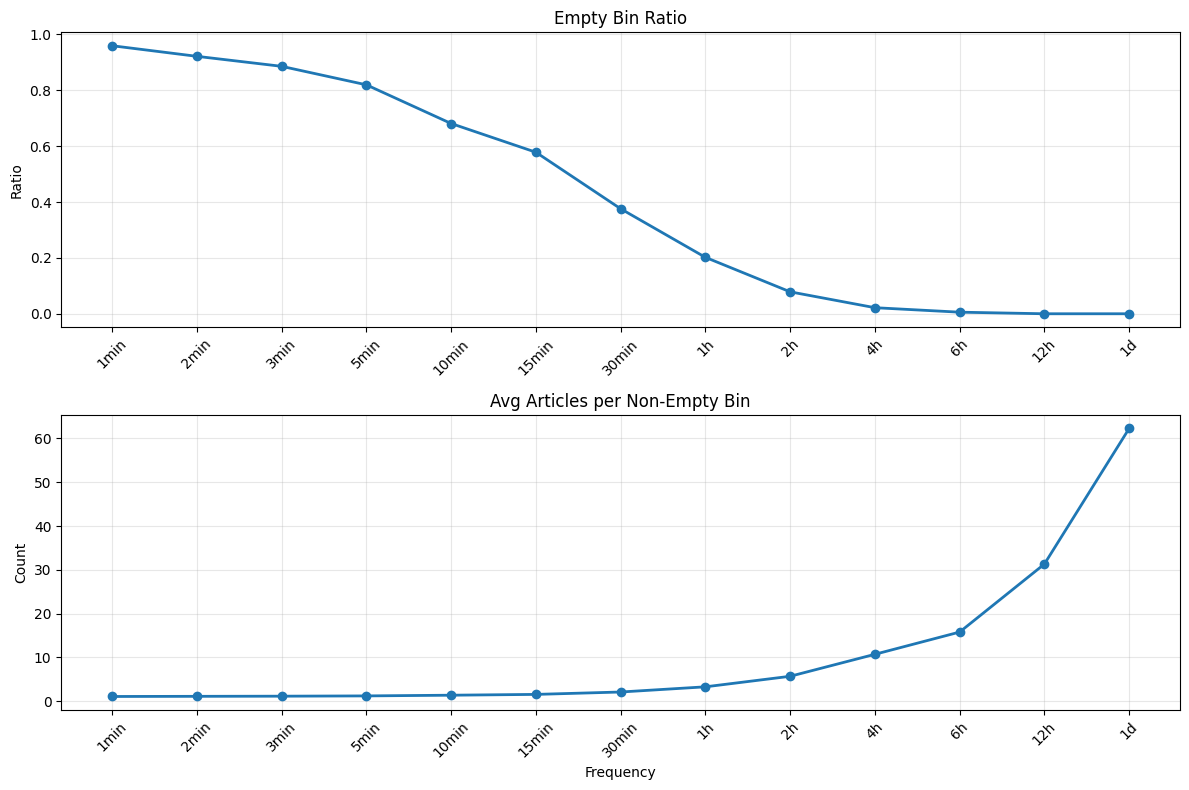

In [512]:
import matplotlib.pyplot as plt

def plot_bin_analysis(bin_df: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 2 rows, 1 column
    
    # Empty bin ratio (top plot)
    axes[0].plot(bin_df['frequency'], bin_df['empty_bin_ratio'], 'o-', linewidth=2, markersize=6)
    axes[0].set_title('Empty Bin Ratio')
    axes[0].set_ylabel('Ratio')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Avg articles per non-empty bin (bottom plot)
    axes[1].plot(bin_df['frequency'], bin_df['avg_articles_per_nonempty_bin'], 'o-', linewidth=2, markersize=6)
    axes[1].set_title('Avg Articles per Non-Empty Bin')
    axes[1].set_ylabel('Count')
    axes[1].set_xlabel('Frequency')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_bin_analysis(bin_analysis)

### Resample news to form a composite sentiment for 1min interval

- currently the sentiment_score 

In [513]:
news_sentiment = news_sentiment.drop(columns=["model_used", "article_id"])
news_sentiment

,time,sentiment_score,sentiment_label,confidence
4929,2025-05-13 22:51:01+00:00,-0.906591,negative,0.942079
4930,2025-05-13 23:08:00+00:00,-0.915050,negative,0.946091
4865,2025-05-14 00:29:02+00:00,0.212853,positive,0.600102
4890,2025-05-14 00:52:04+00:00,-0.914767,negative,0.938012
4896,2025-05-14 01:56:03+00:00,-0.925817,negative,0.949204
...,...,...,...,...
602,2025-11-05 23:19:11+00:00,0.842730,positive,0.907874
601,2025-11-05 23:27:11+00:00,0.870645,positive,0.924907
11082,2025-11-06 00:15:04+00:00,0.340691,positive,0.470724
11081,2025-11-06 00:22:48+00:00,0.886841,positive,0.928342


### Preprocessing News Sentiment And Feature Engineering

In [514]:
import numpy as np

In [515]:
def basic_sentiment_stats(group: pd.DataFrame) -> pd.Series:
    """Compute basic statistics for sentiment scores in a time bucket"""
    return pd.Series({
        'article_count': len(group),
        'sentiment_mean': group['sentiment_score'].mean(),
        'sentiment_median': group['sentiment_score'].median(),
        'sentiment_std': group['sentiment_score'].std(),
        'confidence_mean': group['confidence'].mean(),
        'confidence_std': group['confidence'].std()
    })

In [516]:
def weighted_sentiment_features(group: pd.DataFrame) -> pd.Series:
    """Compute confidence-weighted sentiment metrics"""
    weights = group['confidence']
    total_weight = weights.sum()
    
    if total_weight == 0 or len(group) == 0:
        return pd.Series({
            'weighted_sentiment': np.nan,
            'weighted_std': np.nan,
            'confidence_weighted_count': 0.0
        })
    
    # Weighted sentiment score
    weighted_sentiment = (group['sentiment_score'] * weights).sum() / total_weight
    
    # Weighted standard deviation
    diff = group['sentiment_score'] - weighted_sentiment
    weighted_variance = (weights * (diff ** 2)).sum() / total_weight
    weighted_std = np.sqrt(weighted_variance) if weighted_variance > 0 else 0.0
    
    return pd.Series({
        'weighted_sentiment': weighted_sentiment,
        'weighted_std': weighted_std,
        'confidence_weighted_count': total_weight  # Sum of confidences
    })

In [517]:
def polarity_ratios(group: pd.DataFrame) -> pd.Series:
    """Compute ratios of positive/negative/neutral articles"""
    if len(group) == 0:
        return pd.Series({
            'positive_ratio': 0.0,
            'negative_ratio': 0.0,
            'neutral_ratio': 1.0,
            'polarized_ratio': 0.0
        })
    
    # Define thresholds
    POS_THRESH = 0.05
    NEG_THRESH = -0.05
    HIGH_CONF_THRESH = 0.7
    
    # Count polarized articles (high confidence + strong sentiment)
    polarized = group[
        (group['confidence'] >= HIGH_CONF_THRESH) &
        (abs(group['sentiment_score']) >= 0.5)
    ]
    
    return pd.Series({
        'positive_ratio': (group['sentiment_score'] > POS_THRESH).mean(),
        'negative_ratio': (group['sentiment_score'] < NEG_THRESH).mean(),
        'neutral_ratio': ((group['sentiment_score'] >= NEG_THRESH) & 
                          (group['sentiment_score'] <= POS_THRESH)).mean(),
        'polarized_ratio': len(polarized) / len(group)
    })

In [518]:
def conflict_features(group: pd.DataFrame) -> pd.Series:
    """Detect sentiment conflict/disagreement in time bucket"""
    if len(group) < 2:
        return pd.Series({
            'conflict_score': 0.0,
            'max_disagreement': 0.0,
            'is_high_conflict': False
        })
    
    # High conflict = high volatility + high confidence articles exist
    volatility = group['sentiment_score'].std()
    high_conf_articles = group[group['confidence'] > 0.6]
    
    conflict_score = volatility * (len(high_conf_articles) / len(group))
    max_disagreement = group['sentiment_score'].max() - group['sentiment_score'].min()
    
    # Binary flag for extreme conflict
    is_high_conflict = (volatility > 0.6) and (len(high_conf_articles) >= 2)
    
    return pd.Series({
        'conflict_score': conflict_score,
        'max_disagreement': max_disagreement,
        'is_high_conflict': is_high_conflict
    })

In [519]:
def volatility_centric_features(group: pd.DataFrame) -> pd.Series:
    if group.empty:
        return pd.Series({
            'sentiment_score': 0.0,
            'confidence': 0.0,
            'article_count': 0,
            'volatility': 0.0,
            'is_conflict': False
        })
    
    weights = group['confidence']
    total_weight = weights.sum()
    
    # Weighted sentiment
    if total_weight == 0:
        weighted_score = group['sentiment_score'].mean()
    else:
        weighted_score = (group['sentiment_score'] * weights).sum() / total_weight
    
    # Volatility = std of raw sentiment scores
    volatility = group['sentiment_score'].std()
    if pd.isna(volatility):
        volatility = 0.0
    
    avg_conf = weights.mean()
    is_conflict = (volatility > 0.5) and (avg_conf > 0.6)
    
    return pd.Series({
        'sentiment_score': weighted_score,
        'confidence': avg_conf,
        'article_count': len(group),
        'volatility': volatility,
        'is_conflict': is_conflict
    })

In [520]:
def aggregate_sentiment_features(
    df: pd.DataFrame,
    freq: str = '4h',
    feature_functions: list = None
) -> pd.DataFrame:
    if feature_functions is None:
        feature_functions = [
            basic_sentiment_stats,
            weighted_sentiment_features,
            polarity_ratios,
            conflict_features,
            volatility_centric_features
        ]
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time').sort_index()
    
    buckets = df.resample(freq)
    
    results = []
    for timestamp, group in buckets:
        features = {'time': timestamp}
        for func in feature_functions:
            try:
                func_result = func(group)
                features.update(func_result.to_dict())
            except Exception as e:
                # Fallback for empty or failed groups
                try:
                    empty_df = pd.DataFrame({'sentiment_score': [], 'confidence': []})
                    placeholder = {col: np.nan for col in func(empty_df).index}
                except Exception:
                    placeholder = {}
                features.update(placeholder)
        results.append(features)
    
    result_df = pd.DataFrame(results)
    result_df['time'] = pd.to_datetime(result_df['time'])
    result_df = result_df.set_index('time')
    
    # Extend fillna to cover new volatility columns
    result_df = result_df.fillna({
        'article_count': 0,
        'positive_ratio': 0.0,
        'negative_ratio': 0.0,
        'neutral_ratio': 1.0,
        'polarized_ratio': 0.0,
        'is_high_conflict': False,
        'is_conflict': False,
        'confidence_weighted_count': 0.0,
        'volatility': 0.0,
        'sentiment_score': 0.0,
        'confidence': 0.0
    })
    result_df = result_df.reset_index()  # moves 'time' back to a column
    
    return result_df

In [521]:
sentiment_4h = aggregate_sentiment_features(news_sentiment, freq='4h')
sentiment_4h.head()

,time,article_count,sentiment_mean,sentiment_median,sentiment_std,confidence_mean,confidence_std,weighted_sentiment,weighted_std,confidence_weighted_count,...,negative_ratio,neutral_ratio,polarized_ratio,conflict_score,max_disagreement,is_high_conflict,sentiment_score,confidence,volatility,is_conflict
0,2025-05-13 20:00:00+00:00,2,-0.910821,-0.910821,0.005981,0.944085,0.002837,-0.910830,0.004229,1.888170,...,1.000000,0.0,1.000000,0.005981,0.008459,False,-0.910830,0.944085,0.005981,False
1,2025-05-14 00:00:00+00:00,5,-0.388037,-0.914767,0.745589,0.842368,0.155025,-0.478839,0.648265,4.211842,...,0.600000,0.0,0.800000,0.745589,1.541701,True,-0.478839,0.842368,0.745589,True
2,2025-05-14 04:00:00+00:00,10,-0.032254,0.114001,0.525759,0.732106,0.166292,-0.081831,0.523036,7.321059,...,0.400000,0.1,0.300000,0.420607,1.597487,False,-0.081831,0.732106,0.525759,True
3,2025-05-14 08:00:00+00:00,20,-0.070159,-0.087308,0.582184,0.751101,0.153153,-0.086116,0.604853,15.022011,...,0.550000,0.0,0.450000,0.465747,1.751139,False,-0.086116,0.751101,0.582184,True
4,2025-05-14 12:00:00+00:00,13,-0.396335,-0.672852,0.614174,0.816395,0.129183,-0.428012,0.597249,10.613139,...,0.769231,0.0,0.769231,0.566930,1.779404,True,-0.428012,0.816395,0.614174,True


In [522]:
sentiment_4h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   time                       1058 non-null   datetime64[ns, UTC]
 1   article_count              1058 non-null   int64              
 2   sentiment_mean             1035 non-null   float64            
 3   sentiment_median           1035 non-null   float64            
 4   sentiment_std              989 non-null    float64            
 5   confidence_mean            1035 non-null   float64            
 6   confidence_std             989 non-null    float64            
 7   weighted_sentiment         1035 non-null   float64            
 8   weighted_std               1035 non-null   float64            
 9   confidence_weighted_count  1058 non-null   float64            
 10  positive_ratio             1058 non-null   float64            
 11  nega

### Interpolate fill NaNs using local context: up to `past_window` points before and `future_window` after

In [523]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def local_trend_fill(series: pd.Series, past_window: int = 3, future_window: int = 3, poly_degree: int = 1) -> pd.Series:
    """
    Fill NaNs using local context: up to `past_window` points before and `future_window` after.
    Fits a polynomial (default linear) model on the combined context to fill the gap.
    """
    series = series.copy()
    if series.isna().sum() == 0:
        return series

    # Work with position indices for simplicity
    s = series.copy()
    mask = s.isna()

    # Identify contiguous NaN segments
    # Create a group id for each contiguous NaN block
    na_groups = (~mask).cumsum()
    na_groups = na_groups[mask]

    # If no NaNs, return
    if na_groups.empty:
        return s

    # Iterate over each NaN group
    for group_id in na_groups.unique():
        # Get the indices of this NaN block
        group_mask = (na_groups == group_id)
        nan_idx = group_mask[group_mask].index  # DatetimeIndex of NaNs

        if nan_idx.empty:
            continue

        # Find context: non-NaN points before and after
        start = nan_idx[0]
        end = nan_idx[-1]

        # Get valid points before `start`
        before = s[:start].dropna().iloc[-past_window:] if not s[:start].dropna().empty else pd.Series([], dtype=s.dtype)
        # Get valid points after `end`
        after = s[end:].dropna().iloc[:future_window] if not s[end:].dropna().empty else pd.Series([], dtype=s.dtype)

        context = pd.concat([before, after])
        if len(context) < 2:
            # Not enough points → fall back to forward fill for this gap
            s[nan_idx] = s[:start].iloc[-1] if not s[:start].dropna().empty else np.nan
            continue

        # Prepare features: convert datetime index to numeric (e.g., seconds or ordinal)
        # Use float representation of datetime for stability
        X_context = np.array(context.index.astype('int64')).reshape(-1, 1)
        y_context = context.values

        X_gap = np.array(nan_idx.astype('int64')).reshape(-1, 1)

        if poly_degree == 1:
            model = LinearRegression()
            model.fit(X_context, y_context)
            y_pred = model.predict(X_gap)
        else:
            # Polynomial (e.g., degree 2)
            from sklearn.preprocessing import PolynomialFeatures
            poly = PolynomialFeatures(degree=poly_degree)
            X_poly = poly.fit_transform(X_context)
            model = LinearRegression()
            model.fit(X_poly, y_context)
            X_gap_poly = poly.transform(X_gap)
            y_pred = model.predict(X_gap_poly)

        # Assign predictions
        s[nan_idx] = y_pred

    # Final fallback: forward fill any remaining NaNs (e.g., at start)
    s = s.ffill().bfill()  # bfill handles leading NaNs

    return s

In [524]:
# Make a copy
sentiment_filled = sentiment_4h.copy()

# Process each column
for col in sentiment_filled.columns:
    if pd.api.types.is_bool_dtype(sentiment_filled[col]):
        # Boolean: just forward/backward fill
        sentiment_filled[col] = sentiment_filled[col].ffill().bfill()
    elif pd.api.types.is_numeric_dtype(sentiment_filled[col]):
        sentiment_filled[col] = local_trend_fill(
            sentiment_filled[col],
            past_window=3,
            future_window=3,
            poly_degree=1  # linear; try 2 for quadratic
        )
    else:
        # Fallback
        sentiment_filled[col] = sentiment_filled[col].ffill().bfill()

In [525]:
sentiment_filled.head()

,time,article_count,sentiment_mean,sentiment_median,sentiment_std,confidence_mean,confidence_std,weighted_sentiment,weighted_std,confidence_weighted_count,...,negative_ratio,neutral_ratio,polarized_ratio,conflict_score,max_disagreement,is_high_conflict,sentiment_score,confidence,volatility,is_conflict
0,2025-05-13 20:00:00+00:00,2,-0.910821,-0.910821,0.005981,0.944085,0.002837,-0.910830,0.004229,1.888170,...,1.000000,0.0,1.000000,0.005981,0.008459,False,-0.910830,0.944085,0.005981,False
1,2025-05-14 00:00:00+00:00,5,-0.388037,-0.914767,0.745589,0.842368,0.155025,-0.478839,0.648265,4.211842,...,0.600000,0.0,0.800000,0.745589,1.541701,True,-0.478839,0.842368,0.745589,True
2,2025-05-14 04:00:00+00:00,10,-0.032254,0.114001,0.525759,0.732106,0.166292,-0.081831,0.523036,7.321059,...,0.400000,0.1,0.300000,0.420607,1.597487,False,-0.081831,0.732106,0.525759,True
3,2025-05-14 08:00:00+00:00,20,-0.070159,-0.087308,0.582184,0.751101,0.153153,-0.086116,0.604853,15.022011,...,0.550000,0.0,0.450000,0.465747,1.751139,False,-0.086116,0.751101,0.582184,True
4,2025-05-14 12:00:00+00:00,13,-0.396335,-0.672852,0.614174,0.816395,0.129183,-0.428012,0.597249,10.613139,...,0.769231,0.0,0.769231,0.566930,1.779404,True,-0.428012,0.816395,0.614174,True


In [526]:
sentiment_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   time                       1058 non-null   datetime64[ns, UTC]
 1   article_count              1058 non-null   int64              
 2   sentiment_mean             1058 non-null   float64            
 3   sentiment_median           1058 non-null   float64            
 4   sentiment_std              1058 non-null   float64            
 5   confidence_mean            1058 non-null   float64            
 6   confidence_std             1058 non-null   float64            
 7   weighted_sentiment         1058 non-null   float64            
 8   weighted_std               1058 non-null   float64            
 9   confidence_weighted_count  1058 non-null   float64            
 10  positive_ratio             1058 non-null   float64            
 11  nega

### Visualisation for time series relationships in sentiment

Float columns to plot (17):
['sentiment_mean', 'sentiment_median', 'sentiment_std', 'confidence_mean', 'confidence_std', 'weighted_sentiment', 'weighted_std', 'confidence_weighted_count', 'positive_ratio', 'negative_ratio', 'neutral_ratio', 'polarized_ratio', 'conflict_score', 'max_disagreement', 'sentiment_score', 'confidence', 'volatility']


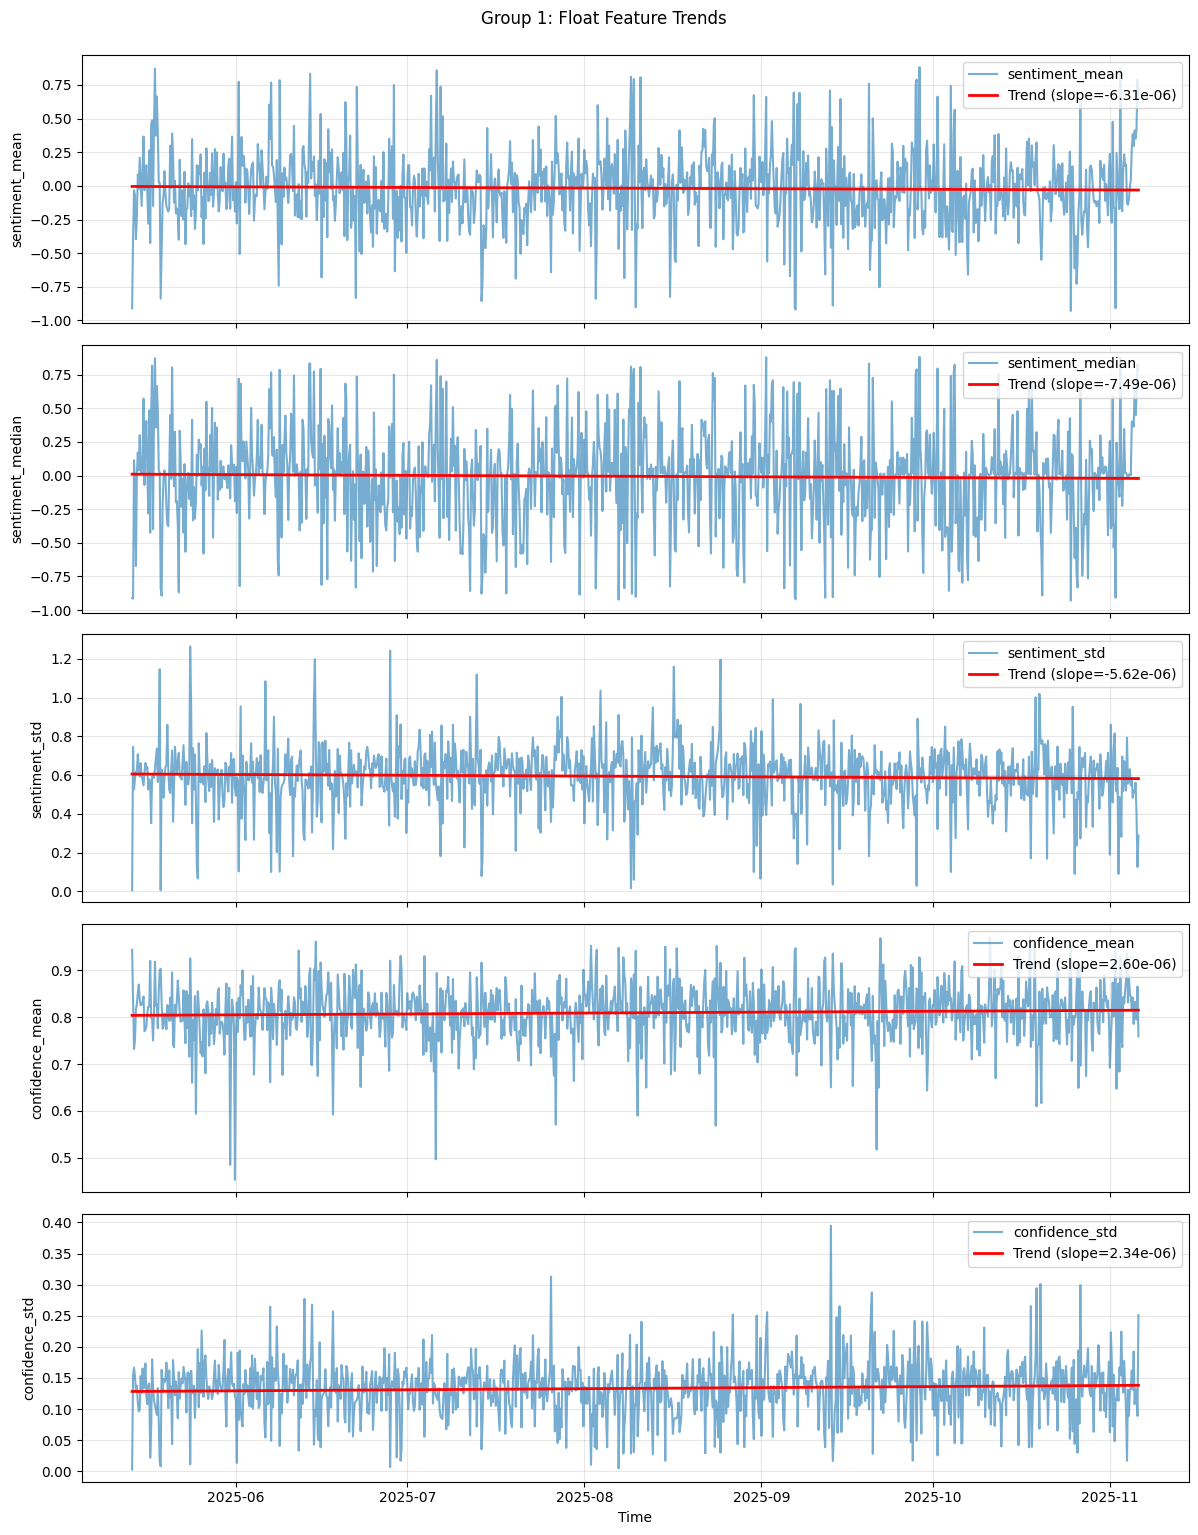

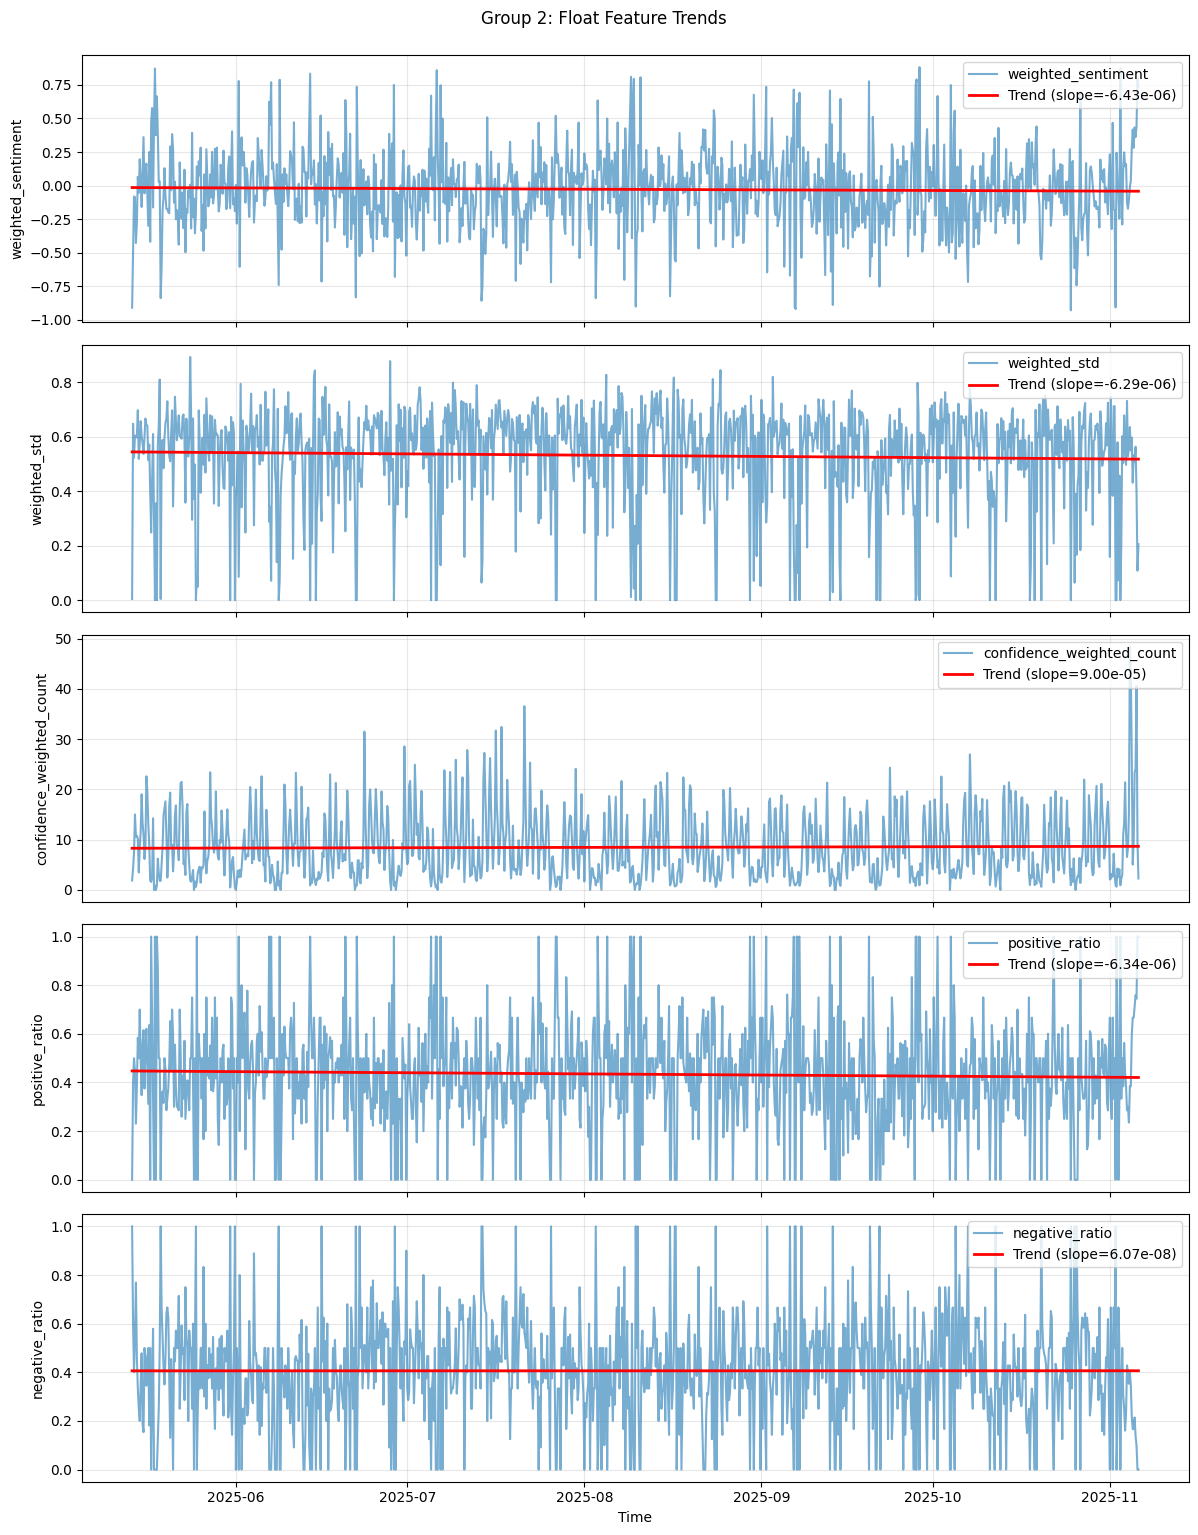

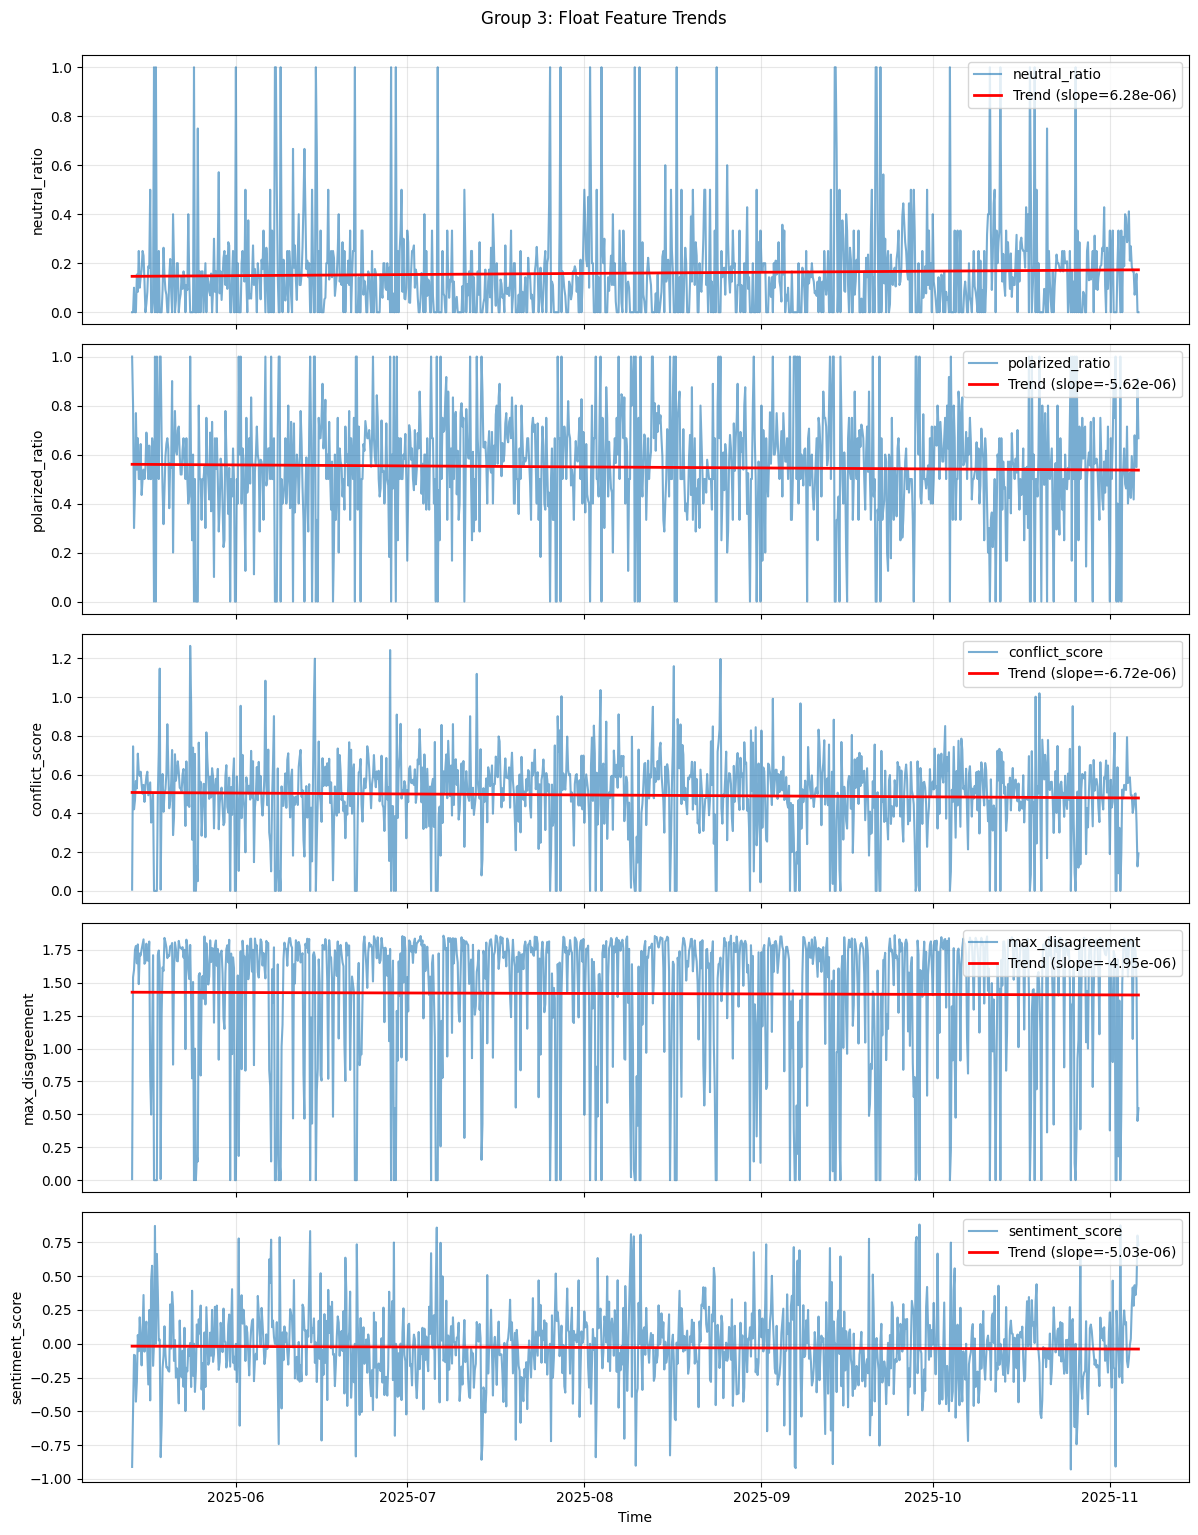

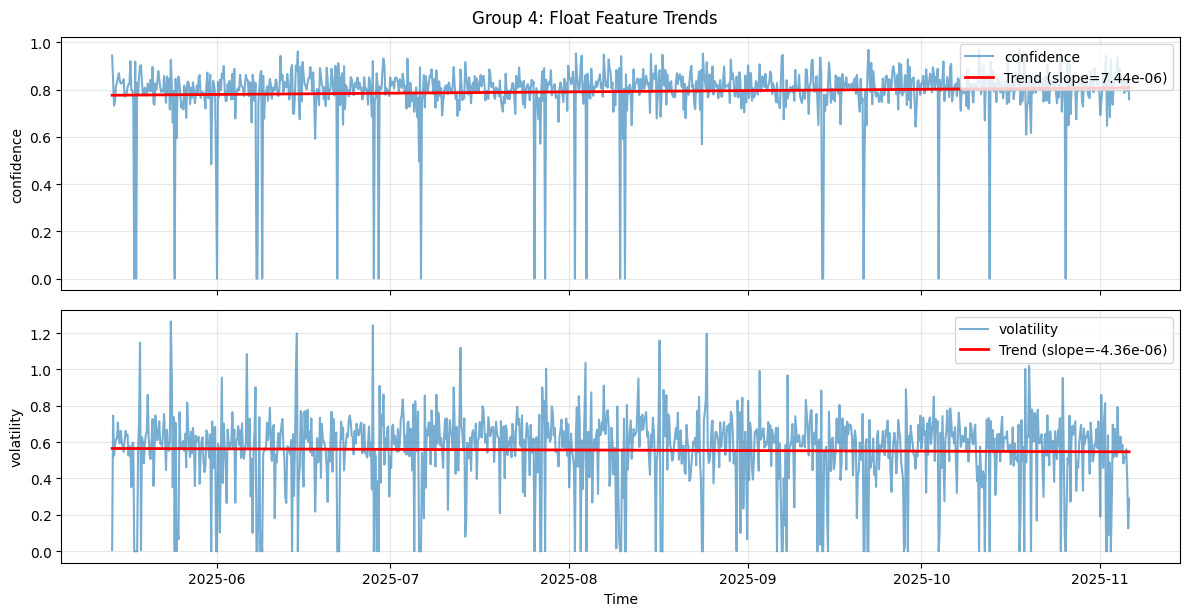

In [527]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'time' is datetime (just in case)
sentiment_filled['time'] = pd.to_datetime(sentiment_filled['time'])

# Identify float columns (exclude 'time', bools, int)
float_cols = [col for col in sentiment_filled.columns if sentiment_filled[col].dtype == 'float64']
print(f"Float columns to plot ({len(float_cols)}):")
print(float_cols)

# Convert 'time' to numeric (hours since first timestamp)
time_col = sentiment_filled['time']
time_numeric = (time_col - time_col.iloc[0]).dt.total_seconds() / 3600  # hours since start

# Helper to split into chunks
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Plot each group
for i, col_group in enumerate(chunks(float_cols, 5)):
    n_plots = len(col_group)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 3 * n_plots), sharex=True)
    if n_plots == 1:
        axes = [axes]

    for ax, col in zip(axes, col_group):
        y = sentiment_filled[col].values

        # Plot raw data
        ax.plot(time_col, y, alpha=0.6, label=col)

        # Fit linear trend
        slope, intercept = np.polyfit(time_numeric, y, 1)
        trend_line = slope * time_numeric + intercept
        ax.plot(time_col, trend_line, color='red', linewidth=2, label=f'Trend (slope={slope:.2e})')

        ax.set_ylabel(col)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.suptitle(f'Group {i+1}: Float Feature Trends', y=1.02)
    plt.show()

## Preprocess Price and Fear and Greed

- change into 4hr granularity

In [528]:
historical_price['time'] = pd.to_datetime(historical_price['time'])
historical_price.set_index('time', inplace=True)

# Resample to 4-hour candles (OHLCV)
price_4h = historical_price.resample('4h').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

price_4h = price_4h.reset_index()
price_4h

,time,open,high,low,close,volume
0,2025-04-30 00:00:00+00:00,94284.00,95135.00,94161.00,95038.00,92.484607
1,2025-04-30 04:00:00+00:00,95061.00,95193.00,94544.00,94654.00,62.534591
2,2025-04-30 08:00:00+00:00,94653.00,95269.00,94556.00,95203.00,97.801509
3,2025-04-30 12:00:00+00:00,95203.00,95240.00,92946.00,94024.00,831.795263
4,2025-04-30 16:00:00+00:00,94022.00,94500.00,93530.00,94148.00,121.045080
...,...,...,...,...,...,...
1136,2025-11-05 08:00:00+00:00,101959.00,102176.00,101183.00,102077.00,305.631556
1137,2025-11-05 12:00:00+00:00,102069.00,103782.00,101908.00,103707.00,649.670542
1138,2025-11-05 16:00:00+00:00,103713.00,104529.41,103075.00,104008.09,3538.369364
1139,2025-11-05 20:00:00+00:00,104008.09,104534.74,103305.05,103885.16,2627.825150


In [529]:
def calculate_rsi(df, column='close', period=14):
    """Calculate the Relative Strength Index (RSI)."""
    delta = df[column].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

In [530]:
def calculate_macd(df, column='close', short_span=12, long_span=26, signal_span=9):
    """Calculate MACD and Signal Line."""
    short_ema = df[column].ewm(span=short_span, adjust=False).mean()
    long_ema = df[column].ewm(span=long_span, adjust=False).mean()
    
    df['MACD'] = short_ema - long_ema
    df['Signal'] = df['MACD'].ewm(span=signal_span, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['Signal']
    return df

In [531]:
def calculate_bollinger_bands(df, column='close', window=20, num_std=2):
    """Calculate Bollinger Bands."""
    df['SMA'] = df[column].rolling(window=window).mean()
    df['STD'] = df[column].rolling(window=window).std()
    df['UpperBand'] = df['SMA'] + (num_std * df['STD'])
    df['LowerBand'] = df['SMA'] - (num_std * df['STD'])
    return df

In [532]:
def calculate_obv(df, close_col='close', vol_col='volume'):
    """Calculate On-Balance Volume (OBV)."""
    df['OBV'] = 0
    df.loc[df[close_col] > df[close_col].shift(1), 'OBV'] = df[vol_col]
    df.loc[df[close_col] < df[close_col].shift(1), 'OBV'] = -df[vol_col]
    df['OBV'] = df['OBV'].cumsum()
    return df


In [533]:
def calculate_vwap(df, price_col='close', vol_col='volume'):
    """Calculate Volume Weighted Average Price (VWAP)."""
    df['Cum_Volume'] = df[vol_col].cumsum()
    df['Cum_Vol_Price'] = (df[price_col] * df[vol_col]).cumsum()
    df['VWAP'] = df['Cum_Vol_Price'] / df['Cum_Volume']
    return df


In [534]:
def generate_signals(df):
    # RSI signal
    df['RSI_Signal'] = 0
    df.loc[df['RSI'] < 30, 'RSI_Signal'] = 1   # bullish (oversold)
    df.loc[df['RSI'] > 70, 'RSI_Signal'] = -1  # bearish (overbought)

    # MACD signal
    df['MACD_Signal'] = 0
    df.loc[df['MACD'] > df['Signal'], 'MACD_Signal'] = 1
    df.loc[df['MACD'] < df['Signal'], 'MACD_Signal'] = -1

    # Bollinger Band signal
    df['BB_Signal'] = 0
    df.loc[df['close'] < df['LowerBand'], 'BB_Signal'] = 1   # bullish
    df.loc[df['close'] > df['UpperBand'], 'BB_Signal'] = -1  # bearish

    # OBV signal
    df['OBV_Signal'] = 0
    df.loc[df['OBV'] > df['OBV'].shift(1), 'OBV_Signal'] = 1
    df.loc[df['OBV'] < df['OBV'].shift(1), 'OBV_Signal'] = -1

    # VWAP signal
    df['VWAP_Signal'] = 0
    df.loc[df['close'] > df['VWAP'], 'VWAP_Signal'] = 1
    df.loc[df['close'] < df['VWAP'], 'VWAP_Signal'] = -1

    # Combined sentiment from all indicators
    signal_cols = ['RSI_Signal', 'MACD_Signal', 'BB_Signal', 'OBV_Signal', 'VWAP_Signal']
    df['Combined_Score'] = df[signal_cols].sum(axis=1)

    # Normalize to -1, 0, 1 (majority vote style)
    df['Combined_Signal'] = df['Combined_Score'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    
    return df


In [535]:
price_4h = calculate_rsi(price_4h)
price_4h = calculate_macd(price_4h)
price_4h = calculate_bollinger_bands(price_4h)
price_4h = calculate_obv(price_4h)
price_4h = calculate_vwap(price_4h)
price_4h = generate_signals(price_4h)
price_4h = price_4h.drop(columns=["Cum_Volume", "Cum_Vol_Price"])

C:\Users\leeee\AppData\Local\Temp\ipykernel_25720\2864512022.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  97.80150923  121.04507954  178.58257669  120.69848147   62.37018534
  286.39046674  618.11245484   80.55292631   78.48990159  301.70090305
   43.62702109   41.90596352   64.33166607   29.63907514   80.20068241
  173.72126467  132.14391673  434.35642723  141.94070251  256.48661993
   66.30178352   51.9781972    98.64489203  217.07392772  175.33174057
  169.54502124  680.64269967  616.85527979  444.0144749   193.09052582
  337.5138578    40.6088916   113.95803982   44.19404484  275.39037632
  104.30449147  113.68979201  365.1693605   177.23452104  122.91456145
   82.79964233  401.9114785   369.68863258   96.09393706  346.39886319
   82.68314656  157.53161586  509.4877789   121.76555053  157.50627989
  218.33992552  145.58561266   66.56578594   31.8664786    51.62254672
  187.52126099  256.667

In [536]:
price_4h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   time             1141 non-null   datetime64[ns, UTC]
 1   open             1141 non-null   float64            
 2   high             1141 non-null   float64            
 3   low              1141 non-null   float64            
 4   close            1141 non-null   float64            
 5   volume           1141 non-null   float64            
 6   RSI              1140 non-null   float64            
 7   MACD             1141 non-null   float64            
 8   Signal           1141 non-null   float64            
 9   MACD_Hist        1141 non-null   float64            
 10  SMA              1122 non-null   float64            
 11  STD              1122 non-null   float64            
 12  UpperBand        1122 non-null   float64            
 13  LowerBand        1

In [537]:
price_4h.head(20)

,time,open,high,low,close,volume,RSI,MACD,Signal,MACD_Hist,...,LowerBand,OBV,VWAP,RSI_Signal,MACD_Signal,BB_Signal,OBV_Signal,VWAP_Signal,Combined_Score,Combined_Signal
0,2025-04-30 00:00:00+00:00,94284.0,95135.0,94161.0,95038.0,92.484607,NaN,0.000000,0.000000,0.000000,...,NaN,0.000000,95038.000000,0,0,0,0,0,0,0
1,2025-04-30 04:00:00+00:00,95061.0,95193.0,94544.0,94654.0,62.534591,0.000000,-30.632479,-6.126496,-24.505983,...,NaN,-62.534591,94883.094780,1,-1,0,-1,-1,-2,-1
2,2025-04-30 08:00:00+00:00,94653.0,95269.0,94556.0,95203.0,97.801509,58.842444,-10.488324,-6.998861,-3.489463,...,NaN,35.266918,95006.847354,0,-1,0,1,1,1,1
3,2025-04-30 12:00:00+00:00,95203.0,95240.0,92946.0,94024.0,831.795263,25.994318,-88.637624,-23.326614,-65.311010,...,NaN,-796.528344,94253.098750,1,-1,0,-1,-1,-2,-1
4,2025-04-30 16:00:00+00:00,94022.0,94500.0,93530.0,94148.0,121.045080,30.098390,-138.963854,-46.454062,-92.509792,...,NaN,-675.483265,94242.547122,0,-1,0,1,-1,-1,-1
5,2025-04-30 20:00:00+00:00,94135.0,94781.0,94035.0,94181.0,178.582577,31.115029,-174.177125,-71.998674,-102.178450,...,NaN,-496.900688,94234.606870,0,-1,0,1,-1,-1,-1
6,2025-05-01 00:00:00+00:00,94181.0,95021.0,94141.0,94799.0,120.698481,45.860755,-150.481800,-87.695299,-62.786500,...,NaN,-376.202207,94279.871996,0,-1,0,1,1,1,1
7,2025-05-01 04:00:00+00:00,94804.0,95193.0,94745.0,95042.0,62.370185,50.063898,-110.817579,-92.319755,-18.497823,...,NaN,-313.832021,94310.200390,0,-1,0,1,1,1,1
8,2025-05-01 08:00:00+00:00,95050.0,96399.0,94934.0,96204.0,286.390467,63.583411,14.216413,-71.012522,85.228935,...,NaN,-27.441554,94602.785677,0,1,0,1,1,3,1
9,2025-05-01 12:00:00+00:00,96236.0,97470.0,95862.0,96918.0,618.112455,68.777467,168.972772,-23.015463,191.988235,...,NaN,590.670900,95181.737858,0,1,0,1,1,3,1


## Data Preparation

#### Merging the price with fear and greed

In [538]:
import pandas as pd

# Ensure both DataFrames are sorted by time
price_4h = price_4h.sort_values('time')
fear_greed = fear_greed.sort_values('time')

price_and_fear = pd.merge_asof(
    price_4h,
    fear_greed,
    on='time',
    direction='backward'
)

### Labels
- lookback window of 7 days which is 42 intervals
- forecast horizon of 12 hours which is 3 intervals

In [539]:
def generate_future_label(df, price_col='close', horizon_hours=12, candle_interval_hours=4, threshold=0.002):
    """
    Generates bullish/bearish labels based on future return over a forecast horizon.
    - 1: bullish (price up)
    - -1: bearish (price down)
    - 0: neutral (small change)
    """
    horizon = int(horizon_hours / candle_interval_hours)
    df = df.copy()
    df['future_return'] = (df[price_col].shift(-horizon) - df[price_col]) / df[price_col]

    df['label'] = 0
    df.loc[df['future_return'] > threshold, 'label'] = 1
    df.loc[df['future_return'] < -threshold, 'label'] = -1
    return df


In [540]:
def add_rolling_features(df, price_col='close', window_days=7, candle_interval_hours=4):
    """
    Adds rolling volatility and return features based on past N days.
    """
    window = int((24 / candle_interval_hours) * window_days)
    df = df.copy()
    df['rolling_volatility'] = df[price_col].pct_change().rolling(window).std()
    df['rolling_return'] = df[price_col].pct_change(window)
    return df

In [541]:
price_and_fear = add_rolling_features(price_and_fear, window_days=7, candle_interval_hours=4)

price_and_fear = generate_future_label(price_and_fear, horizon_hours=12, candle_interval_hours=4)

In [542]:
price_and_fear.head()

,time,open,high,low,close,volume,RSI,MACD,Signal,MACD_Hist,...,OBV_Signal,VWAP_Signal,Combined_Score,Combined_Signal,value,value_classification,rolling_volatility,rolling_return,future_return,label
0,2025-04-30 00:00:00+00:00,94284.0,95135.0,94161.0,95038.0,92.484607,NaN,0.000000,0.000000,0.000000,...,0,0,0,0,NaN,NaN,NaN,NaN,-0.010669,-1
1,2025-04-30 04:00:00+00:00,95061.0,95193.0,94544.0,94654.0,62.534591,0.000000,-30.632479,-6.126496,-24.505983,...,-1,-1,-2,-1,NaN,NaN,NaN,NaN,-0.005346,-1
2,2025-04-30 08:00:00+00:00,94653.0,95269.0,94556.0,95203.0,97.801509,58.842444,-10.488324,-6.998861,-3.489463,...,1,1,1,1,NaN,NaN,NaN,NaN,-0.010735,-1
3,2025-04-30 12:00:00+00:00,95203.0,95240.0,92946.0,94024.0,831.795263,25.994318,-88.637624,-23.326614,-65.311010,...,-1,-1,-2,-1,NaN,NaN,NaN,NaN,0.008243,1
4,2025-04-30 16:00:00+00:00,94022.0,94500.0,93530.0,94148.0,121.045080,30.098390,-138.963854,-46.454062,-92.509792,...,1,-1,-1,-1,NaN,NaN,NaN,NaN,0.009496,1


### Join with news data

In [543]:
price_and_fear = price_and_fear.sort_values("time")
sentiment_filled = sentiment_filled.sort_values("time")


def merge_sentiment_with_price(price_df, sentiment_df, price_time_col='time', sentiment_time_col='time'):
    """
    Merge lower-frequency sentiment data with higher-frequency price data.

    Each sentiment timestamp gets matched to the most recent prior price candle.
    The merged result keeps sentiment_df's timestamps as reference.
    """
    # Ensure both are sorted by time
    price_df = price_df.sort_values(price_time_col)
    sentiment_df = sentiment_df.sort_values(sentiment_time_col)

    # Perform backward merge: take last available price before sentiment time
    merged = pd.merge_asof(
        sentiment_df,
        price_and_fear,
        left_on=sentiment_time_col,
        right_on=price_time_col,
        direction='backward'
    )

    return merged


In [544]:
price_fear_sentiment = merge_sentiment_with_price(
    price_4h,           # your 4-hour price data
    sentiment_filled,     # your news sentiment DataFrame
    price_time_col='time',
    sentiment_time_col='time'
)

In [545]:
price_fear_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   time                       1058 non-null   datetime64[ns, UTC]
 1   article_count              1058 non-null   int64              
 2   sentiment_mean             1058 non-null   float64            
 3   sentiment_median           1058 non-null   float64            
 4   sentiment_std              1058 non-null   float64            
 5   confidence_mean            1058 non-null   float64            
 6   confidence_std             1058 non-null   float64            
 7   weighted_sentiment         1058 non-null   float64            
 8   weighted_std               1058 non-null   float64            
 9   confidence_weighted_count  1058 non-null   float64            
 10  positive_ratio             1058 non-null   float64            
 11  nega

In [546]:
price_fear_sentiment = price_fear_sentiment.rename(columns={"value": "fng_score"})

In [547]:
price_fear_sentiment.columns

Index(['time', 'article_count', 'sentiment_mean', 'sentiment_median',
       'sentiment_std', 'confidence_mean', 'confidence_std',
       'weighted_sentiment', 'weighted_std', 'confidence_weighted_count',
       'positive_ratio', 'negative_ratio', 'neutral_ratio', 'polarized_ratio',
       'conflict_score', 'max_disagreement', 'is_high_conflict',
       'sentiment_score', 'confidence', 'volatility', 'is_conflict', 'open',
       'high', 'low', 'close', 'volume', 'RSI', 'MACD', 'Signal', 'MACD_Hist',
       'SMA', 'STD', 'UpperBand', 'LowerBand', 'OBV', 'VWAP', 'RSI_Signal',
       'MACD_Signal', 'BB_Signal', 'OBV_Signal', 'VWAP_Signal',
       'Combined_Score', 'Combined_Signal', 'fng_score',
       'value_classification', 'rolling_volatility', 'rolling_return',
       'future_return', 'label'],
      dtype='object')

# Feature Set preparation + Training Data preparation

### Feature set and labels + training sequences

In [548]:
feature_cols = [
    # --- Sentiment-based features ---
    'article_count', 'sentiment_mean', 'sentiment_median', 'sentiment_std',
    'confidence_mean', 'confidence_std', 'weighted_sentiment', 'weighted_std',
    'confidence_weighted_count', 'positive_ratio', 'negative_ratio', 'neutral_ratio',
    'polarized_ratio', 'conflict_score', 'max_disagreement', 'is_high_conflict',
    'sentiment_score', 'confidence', 'volatility', 'is_conflict',

    # --- Price & Technical Indicators ---
    'open', 'high', 'low', 'close', 'volume', 'RSI', 'MACD', 'Signal', 'MACD_Hist',
    'SMA', 'STD', 'UpperBand', 'LowerBand', 'OBV', 'VWAP',

    # --- Derived Signals ---
    'RSI_Signal', 'MACD_Signal', 'BB_Signal', 'OBV_Signal', 'VWAP_Signal',
    'Combined_Signal', 'fng_score',  # Fear & Greed score
    'rolling_volatility', 'rolling_return'
]


In [549]:
df = price_fear_sentiment.sort_values('time')
df = df.dropna(subset=feature_cols + ['label']).reset_index(drop=True)

In [550]:
import numpy as np

def create_sequences(df, feature_cols, lookback=42, forecast_horizon=3, label_col='label'):
    """
    Create rolling sequences: past `lookback` steps to predict label `forecast_horizon` ahead.
    """
    X, y, timestamps = [], [], []
    data = df[feature_cols].values
    labels = df[label_col].values
    times = df['time'].values
    
    for i in range(lookback, len(df) - forecast_horizon):
        X.append(data[i - lookback:i])                 # past 7 days (42 intervals)
        y.append(labels[i + forecast_horizon - 1])     # label 3 intervals ahead (12h)
        timestamps.append(times[i])
    
    return np.array(X), np.array(y), np.array(timestamps)


In [551]:
X, y, t = create_sequences(
    df,
    feature_cols=feature_cols,
    lookback=42,
    forecast_horizon=3,
    label_col='label'
)

print("✅ Features shape:", X.shape)
print("✅ Labels shape:", y.shape)
print("✅ Unique labels:", np.unique(y, return_counts=True))


✅ Features shape: (1013, 42, 44)
✅ Labels shape: (1013,)
✅ Unique labels: (array([-1,  0,  1]), array([398, 177, 438]))


### Train test split

In [552]:
split_ratio = 0.85
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
t_train, t_test = t[:split_idx], t[split_idx:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 861, Test: 152


## Model Training

In [553]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [554]:
def scale_and_create_sequences(df, feature_cols, label_col='label', lookback=42, forecast_horizon=3):
    """
    Scale features and create rolling sequences for training.
    """
    # --- Scale features ---
    scaler = StandardScaler()
    scaled_df = df.copy()
    scaled_df[feature_cols] = scaler.fit_transform(df[feature_cols])

    # --- Create sequences ---
    X, y, timestamps = [], [], []
    data = scaled_df[feature_cols].values
    labels = scaled_df[label_col].values
    times = scaled_df['time'].values

    for i in range(lookback, len(df) - forecast_horizon):
        X.append(data[i - lookback:i])
        y.append(labels[i + forecast_horizon - 1])
        timestamps.append(times[i])

    X = np.array(X)
    y = np.array(y)
    return X, y, np.array(timestamps), scaler

In [555]:
class PriceSentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)  # classification labels (-1,0,1) encoded as ints

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_dataloaders(X, y, split_ratio=0.8, batch_size=64):
    """
    Split into train/test and create DataLoaders.
    """
    split_idx = int(len(X) * split_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    train_ds = PriceSentimentDataset(X_train, y_train)
    test_ds = PriceSentimentDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

#### Model Architecture

In [556]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, num_classes=3, dropout=0.4):
        super().__init__()
        
        # --- LSTM encoder (stacked) ---
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True    # use bidirectional LSTM
        )

        # --- Add normalization and residual dense blocks ---
        self.norm1 = nn.LayerNorm(hidden_dim * 2)
        self.dropout1 = nn.Dropout(dropout)

        # --- Two fully connected hidden layers with GELU ---
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, num_classes)

        # --- Optional residual connection ---
        self.residual = nn.Linear(hidden_dim * 2, 64)

    def forward(self, x):
        # LSTM encoding
        lstm_out, (h, c) = self.lstm(x)

        # concatenate both directions' last hidden states
        last_hidden = torch.cat((h[-2], h[-1]), dim=1)

        # normalize + dropout
        x = self.norm1(last_hidden)
        x = self.dropout1(x)

        # feed-forward with nonlinearities
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))

        # residual path from LSTM output to dense representation
        x = x + self.residual(last_hidden)

        # output logits
        x = self.fc_out(x)
        return x


In [557]:
def train_model(model, train_loader, test_loader, epochs=25, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"🚀 Training on {device}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate accuracy
        acc = evaluate_model(model, test_loader, device=device, silent=True)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(train_loader):.4f} | Test Acc: {acc:.4f}")

    return model


def evaluate_model(model, loader, device=None, silent=False):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = correct / total
    if not silent:
        print(f"\nClassification Report:\n{classification_report(y_true, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'])}")
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    return acc


#### Full pipeline runner

In [562]:
def run_lstm_pipeline(df, feature_cols, label_col='label', lookback=42, forecast_horizon=3, epochs=25):
    """
    Full end-to-end training pipeline for the LSTM classifier.
    """

    df = df.copy()
    if df[label_col].min() < 0:
        df[label_col] = df[label_col].map({-1: 0, 0: 1, 1: 2})

    X, y, timestamps, scaler = scale_and_create_sequences(df, feature_cols, label_col, lookback, forecast_horizon)
    train_loader, test_loader = get_dataloaders(X, y, split_ratio=0.8, batch_size=16)

    input_dim = X.shape[2]
    model = LSTMClassifier(input_dim=input_dim)
    model = train_model(model, train_loader, test_loader, epochs=epochs)

    print("\n✅ Final Evaluation:")
    evaluate_model(model, test_loader)
    return model, scaler

In [563]:
model, scaler = run_lstm_pipeline(
    df=price_fear_sentiment,
    feature_cols=feature_cols,
    label_col='label',
    lookback=42,
    forecast_horizon=3,
    epochs=100
)

🚀 Training on cpu
Epoch [1/100] | Loss: 1.0478 | Test Acc: 0.4335
Epoch [2/100] | Loss: 1.0280 | Test Acc: 0.4877
Epoch [3/100] | Loss: 0.9961 | Test Acc: 0.4631
Epoch [4/100] | Loss: 0.9751 | Test Acc: 0.4926
Epoch [5/100] | Loss: 0.9355 | Test Acc: 0.5074
Epoch [6/100] | Loss: 0.8941 | Test Acc: 0.4138
Epoch [7/100] | Loss: 0.8646 | Test Acc: 0.4828
Epoch [8/100] | Loss: 0.8087 | Test Acc: 0.4187
Epoch [9/100] | Loss: 0.7656 | Test Acc: 0.4384
Epoch [10/100] | Loss: 0.6796 | Test Acc: 0.4187
Epoch [11/100] | Loss: 0.6309 | Test Acc: 0.4089
Epoch [12/100] | Loss: 0.5991 | Test Acc: 0.4236
Epoch [13/100] | Loss: 0.5284 | Test Acc: 0.3990
Epoch [14/100] | Loss: 0.4670 | Test Acc: 0.3892
Epoch [15/100] | Loss: 0.4652 | Test Acc: 0.4138
Epoch [16/100] | Loss: 0.4236 | Test Acc: 0.3744
Epoch [17/100] | Loss: 0.3869 | Test Acc: 0.4187
Epoch [18/100] | Loss: 0.3744 | Test Acc: 0.3793
Epoch [19/100] | Loss: 0.3353 | Test Acc: 0.4138
Epoch [20/100] | Loss: 0.2696 | Test Acc: 0.4187
Epoch [21/1

#### Parameter Tuning 

In [560]:
def ensure_time_column(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure 'time' is a column (not index), and is datetime."""
    df = df.copy()
    if df.index.name == 'time' or 'time' not in df.columns:
        df = df.reset_index()
    if 'time' not in df.columns:
        raise ValueError("DataFrame must contain a 'time' column or index named 'time'")
    df['time'] = pd.to_datetime(df['time'])
    return df


def evaluate_bin_frequency(
    news_df: pd.DataFrame,
    price_df: pd.DataFrame,
    fear_greed_df: pd.DataFrame,
    bin_freq: str = '4h',
    lookback: int = 42,
    forecast_horizon: int = 3,
    epochs: int = 15,  # reduce for faster iteration
    threshold: float = 0.002,
    candle_interval_hours: int = 4,
    verbose: bool = False
) -> dict:
    """
    Full pipeline: bin news → merge → train LSTM → return metrics.
    
    Returns:
        dict with keys: 'bin_freq', 'accuracy', 'f1_weighted', 'support'
    """
    from sklearn.metrics import classification_report, accuracy_score
    import torch
    news_df = ensure_time_column(news_df)
    price_df = ensure_time_column(price_df)
    fear_greed_df = ensure_time_column(fear_greed_df)
    # --- Step 1: Bin and aggregate sentiment ---
    sentiment_binned = aggregate_sentiment_features(news_df, freq=bin_freq)
    
    # --- Step 2: Interpolate missing values ---
    sentiment_filled = sentiment_binned.copy()
    for col in sentiment_filled.columns:
        if pd.api.types.is_bool_dtype(sentiment_filled[col]):
            sentiment_filled[col] = sentiment_filled[col].ffill().bfill()
        elif pd.api.types.is_numeric_dtype(sentiment_filled[col]):
            sentiment_filled[col] = local_trend_fill(
                sentiment_filled[col], past_window=3, future_window=3, poly_degree=1
            )
        else:
            sentiment_filled[col] = sentiment_filled[col].ffill().bfill()

    # --- Step 3: Resample price to match bin_freq (must be compatible!) ---
    price_df = price_df.copy()
    price_df['time'] = pd.to_datetime(price_df['time'])
    price_df = price_df.set_index('time').sort_index()
    
    # OHLCV resampling at the same frequency as sentiment
    price_binned = price_df.resample(bin_freq).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna().reset_index()

    # Skip if too little data
    if len(price_binned) < lookback + forecast_horizon + 10:
        if verbose:
            print(f"⚠️ Not enough price data for bin_freq={bin_freq}")
        return {'bin_freq': bin_freq, 'accuracy': 0.0, 'f1_weighted': 0.0, 'support': 0}

    # --- Step 4: Add technical indicators ---
    price_binned = calculate_rsi(price_binned)
    price_binned = calculate_macd(price_binned)
    price_binned = calculate_bollinger_bands(price_binned)
    price_binned = calculate_obv(price_binned)
    price_binned = calculate_vwap(price_binned)
    price_binned = generate_signals(price_binned)
    price_binned = price_binned.drop(columns=["Cum_Volume", "Cum_Vol_Price"], errors='ignore')

    # --- Step 5: Add rolling features & labels ---
    price_binned = add_rolling_features(
        price_binned, 
        window_days=7, 
        candle_interval_hours=candle_interval_hours
    )
    price_binned = generate_future_label(
        price_binned, 
        horizon_hours=forecast_horizon * candle_interval_hours,
        candle_interval_hours=candle_interval_hours,
        threshold=threshold
    )

    # --- Step 6: Merge with fear & greed (asof) ---
    fear_greed_df = fear_greed_df.copy().sort_values('time')
    price_binned = price_binned.sort_values('time')
    price_fear = pd.merge_asof(
        price_binned,
        fear_greed_df.rename(columns={'value': 'fng_score'}),
        on='time',
        direction='backward'
    )

    # --- Step 7: Merge with sentiment ---
    sentiment_filled = sentiment_filled.sort_values('time')
    full_df = pd.merge_asof(
        sentiment_filled,
        price_fear,
        on='time',
        direction='backward'
    )

    # --- Step 8: Define features and drop NaNs ---
    feature_cols = [
        # Sentiment
        'article_count', 'sentiment_mean', 'sentiment_median', 'sentiment_std',
        'confidence_mean', 'confidence_std', 'weighted_sentiment', 'weighted_std',
        'confidence_weighted_count', 'positive_ratio', 'negative_ratio', 'neutral_ratio',
        'polarized_ratio', 'conflict_score', 'max_disagreement', 'is_high_conflict',
        'sentiment_score', 'confidence', 'volatility', 'is_conflict',
        # Price & TA
        'open', 'high', 'low', 'close', 'volume', 'RSI', 'MACD', 'Signal', 'MACD_Hist',
        'SMA', 'STD', 'UpperBand', 'LowerBand', 'OBV', 'VWAP',
        'RSI_Signal', 'MACD_Signal', 'BB_Signal', 'OBV_Signal', 'VWAP_Signal',
        'Combined_Signal', 'fng_score', 'rolling_volatility', 'rolling_return'
    ]

    df_clean = full_df.dropna(subset=feature_cols + ['label']).reset_index(drop=True)
    
    if len(df_clean) < lookback + 10:
        return {'bin_freq': bin_freq, 'accuracy': 0.0, 'f1_weighted': 0.0, 'support': 0}

    # Adjust labels if needed
    df_clean = df_clean.copy()
    if df_clean['label'].min() < 0:
        df_clean['label'] = df_clean['label'].map({-1: 0, 0: 1, 1: 2})

    # --- Step 9: Scale and create sequences ---
    X, y, _, scaler = scale_and_create_sequences(
        df_clean, feature_cols, label_col='label', 
        lookback=lookback, forecast_horizon=forecast_horizon
    )

    if len(X) == 0:
        return {'bin_freq': bin_freq, 'accuracy': 0.0, 'f1_weighted': 0.0, 'support': 0}

    # --- Step 10: Train/test split and DataLoader ---
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    train_ds = PriceSentimentDataset(X_train, y_train)
    test_ds = PriceSentimentDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    # --- Step 11: Train model ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMClassifier(input_dim=X.shape[2]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Simple training loop (short for speed)
    model.train()
    for _ in range(epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # --- Step 12: Evaluate ---
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(pred)
            all_true.extend(yb.cpu().numpy())

    acc = accuracy_score(all_true, all_preds)
    report = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    f1_weighted = report['weighted avg']['f1-score']
    
    result = {
        'bin_freq': bin_freq,
        'accuracy': acc,
        'f1_weighted': f1_weighted,
        'support': len(all_true)
    }
    
    if verbose:
        print(f"✅ {bin_freq}: Acc={acc:.4f}, F1={f1_weighted:.4f}, N={len(all_true)}")
    
    return result

In [561]:
candidate_freqs = ['1h', '2h', '4h', '6h', '12h', '1d']

results = []
for freq in candidate_freqs:
    try:
        res = evaluate_bin_frequency(
            news_df=news_sentiment,
            price_df=historical_price,
            fear_greed_df=fear_greed,
            bin_freq=freq,
            epochs=50,  # keep low for quick iteration
            verbose=True
        )
        results.append(res)
    except Exception as e:
        print(f"❌ Failed for {freq}: {e}")
        results.append({'bin_freq': freq, 'accuracy': 0, 'f1_weighted': 0, 'support': 0})

# Convert to DataFrame and sort by F1 or accuracy
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1_weighted', ascending=False)
print("\n" + "="*60)
print("BINNING PERFORMANCE RANKING (by F1):")
print(results_df.to_string(index=False))

C:\Users\leeee\AppData\Local\Temp\ipykernel_25720\2864512022.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 26.11946297  20.20990587   7.46973661 ... 685.25627    504.79132
   1.39209   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[close_col] > df[close_col].shift(1), 'OBV'] = df[vol_col]


KeyboardInterrupt: 